In [1]:
import sys
import numpy as np
import torch
from torch import nn
from torch.autograd import gradcheck

import matplotlib.pyplot as plt
import pandas as pd

import mnp

In [2]:
#Check Gradient
n = 5
layer_sizes = np.ones(1, dtype=np.int64)
layer_sizes *= 1

#Generate input for DSF
s_input, m_input = mnp.gen_deep_submodular_bernoulli(n, layer_sizes, p=0.2)
s_input += 0.5 #Needed for layers - eps to be positive
s_input = torch.tensor(s_input, requires_grad=True)
m_input = torch.zeros(n)
test = gradcheck(mnp.DeepSubmodular.apply, (s_input, m_input, n, layer_sizes), eps=1e-6, atol=.1)
print(test)
#Note:test fails for modular weights but I believe this is a problem with gradcheck

#Generate input for LogQ loss
#y = torch.rand(n, requires_grad=True, dtype=torch.float64)
#y_gt = torch.rand(n, dtype=torch.float64)
#test = gradcheck(mnp.LogQ.apply, (y, y_gt), eps=1e-6, atol=1e-4)
#print(test)

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 0.4700, -0.0768, -0.0949, -0.2079, -0.0686],
        [ 0.0000,  0.3932, -0.0949, -0.2079, -0.0686],
        [ 0.0000,  0.0000,  0.2983, -0.2079, -0.0686],
        [ 0.0000,  0.0000,  0.0000,  0.0904, -0.0686],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0217]], dtype=torch.float64)
analytical:tensor([[ 0.2100, -0.0698, -0.0499,  0.0000, -0.0686],
        [ 0.0000,  0.1402, -0.0499,  0.0000, -0.0686],
        [ 0.0000,  0.0000,  0.0904,  0.0000, -0.0686],
        [-0.0883, -0.0698, -0.0499,  0.2983, -0.0686],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0217]], dtype=torch.float64)


In [5]:
#First generate a submodular set function that we want to fit
#For now, generate a submodular set function
n = 100
layer_sizes = np.ones(3, dtype=np.int64)
layer_sizes *= 10

sub_weights_gt, mod_weights_gt = mnp.gen_deep_submodular_bernoulli(n, layer_sizes, p=0.2)
FA_gt, yprime_gt = mnp.mnp_deep_contig_w(n, layer_sizes, sub_weights_gt, mod_weights_gt)

card = np.count_nonzero(yprime_gt <= 0.0)
print('Ground Truth F_A*:\t' + str(FA_gt))
print('Ground Truth |A*|:\t' + str(card))
#A = yprime_gt <= 0.0
#F_A = mnp.dsf_eval(n, layer_sizes, sub_weights_gt, mod_weights_gt,  A)
#print('Ground Truth F_A*:\t' + str(F_A))

A_gt = torch.ones(n, dtype=torch.float64)
for i in range(n):
    if yprime_gt[i].item() <= 0.0:
        A_gt[i] = 1.0
    else:
        A_gt[i] = 0.0

yprime_gt = torch.tensor(yprime_gt)


Ground Truth F_A*:	-22.494138683791782
Ground Truth |A*|:	53


iteration 0 loss 69.88918195251304
iteration 50 loss 4.187084203190361
iteration 100 loss 2.069122209327383
iteration 150 loss 1.3698765970101519
iteration 200 loss 1.0229349089563833
iteration 250 loss 0.8158406274981942
 F_A -182.5180314048955


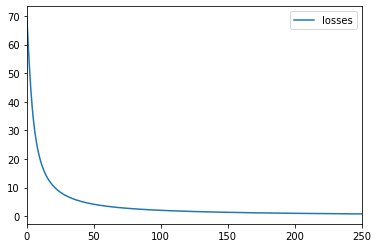

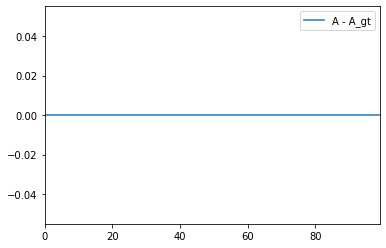

In [16]:
#Initalize weights/variables
s_weights, m_weights = mnp.gen_deep_submodular_bernoulli(n, layer_sizes,p=0.2)
s_weights = torch.tensor(s_weights, requires_grad=True)
m_weights = torch.tensor(m_weights, requires_grad=True)

#Create Model
deep_mnp = mnp.DeepSubmodular.apply
loss_fn = mnp.LogQ(A_gt)

#Use SGD
optimizer = torch.optim.SGD([s_weights, m_weights], lr=5e-1)

losses = []
best_loss = 0
for iter_num in range(251):
    optimizer.zero_grad()
    
    yprime = deep_mnp(s_weights, m_weights, n, layer_sizes)
    loss = loss_fn(yprime)

    loss.backward(retain_graph=True)
    optimizer.step()
    s_weights.data.clamp_(min=0.0)
    
    if iter_num % 50 == 0:   
        print('iteration ' + str(iter_num) + ' loss ' + str(loss.item()), end = '\n')
    losses.append(loss.item())
        
    if(iter_num == 0 or loss < best_loss):
        best_loss = loss
        best_s_weights = s_weights
        best_m_weights = m_weights
        
A = (yprime <= 0.0).numpy()
F_A = mnp.dsf_eval(n, layer_sizes, s_weights.detach().numpy(), m_weights.detach().numpy(),  A)
print(' F_A ' + str (F_A))
       
df = pd.DataFrame(losses, columns=('losses',))
df.plot()
df = pd.DataFrame(A-A_gt.numpy(), columns=('A - A_gt',))
df.plot()
plt.show()

Ground Truth F_A*:	-0.4326468028840047
Ground Truth |A*|:	38
iteration 0 loss 79.20851657328782
iteration 50 loss 0.9823457070603563
iteration 100 loss 0.525922460697795
iteration 150 loss 0.39553967888140007
iteration 200 loss 0.32993655760797386
iteration 250 loss 0.28855328986922135
 F_A -218.03432634491605


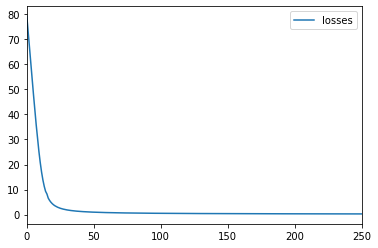

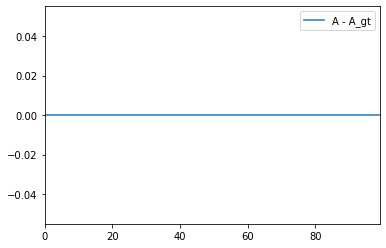

In [15]:
#First generate a submodular set function that we want to fit
#For now, generate a mincut function
n = 100
FA_gt, yprime_gt = mnp.watts_strogatz_graph_cut_yprime(n, 16, 0.25)

card = np.count_nonzero(yprime_gt <= 0.0)
print('Ground Truth F_A*:\t' + str(FA_gt))
print('Ground Truth |A*|:\t' + str(card))

yprime_gt = torch.tensor(yprime_gt)

A_gt = torch.ones(n, dtype=torch.float64)
for i in range(n):
    if yprime_gt[i].item() <= 0.0:
        A_gt[i] = 1.0
    else:
        A_gt[i] = 0.0

#Create Model
deep_mnp = mnp.DeepSubmodular.apply
loss_fn = mnp.LogQ(A_gt)

#Use SGD
optimizer = torch.optim.SGD([s_weights, m_weights], lr=5e-1)

losses = []
best_loss = 0
for iter_num in range(251):
    optimizer.zero_grad()
    
    yprime = deep_mnp(s_weights, m_weights, n, layer_sizes)
    loss = loss_fn(yprime)

    loss.backward(retain_graph=True)
    optimizer.step()
    s_weights.data.clamp_(min=0.0)
    
    if iter_num % 50 == 0:   
        print('iteration ' + str(iter_num) + ' loss ' + str(loss.item()), end = '\n')
    losses.append(loss.item())
        
    if(iter_num == 0 or loss < best_loss):
        best_loss = loss
        best_s_weights = s_weights
        best_m_weights = m_weights
        
A = (yprime <= 0.0).numpy()
F_A = mnp.dsf_eval(n, layer_sizes, s_weights.detach().numpy(), m_weights.detach().numpy(),  A)
print(' F_A ' + str (F_A))
       
df = pd.DataFrame(losses, columns=('losses',))
df.plot()
df = pd.DataFrame(A-A_gt.numpy(), columns=('A - A_gt',))
df.plot()
plt.show()